THƯ VIỆN

In [68]:
import os
import glob
import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.fftpack as fftpack
import scipy.signal as signal
import librosa
import librosa.display
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier
import xgboost as xgb

ML MODEL

In [69]:
logistic = LogisticRegression(max_iter = 1000)
svm = SVC(kernel = 'rbf', C = 1, gamma = 'scale')
knn = KNeighborsClassifier(n_neighbors = 5)
random_forest = RandomForestClassifier()
extra_tree = ExtraTreeClassifier()
xgboost = xgb.XGBClassifier()
models = {
    "Logistic Regression": logistic,
    "SVM": svm,
    "KNN": knn,
    "Random Forest": random_forest,
    "Extra Tree": extra_tree,
    "XGBoost": xgboost,
}

MFCCs

In [77]:
def create_mfcc_features(file_path, sr=16000, n_mfcc = 39, n_fft=512, hop_length=160, win_length=400, max_freq=1200, n_mels = 40, htk=False):
    try:
        # Đọc tệp âm thanh
        y, sr = librosa.load(file_path, sr=sr)
        
        mfccs = librosa.feature.mfcc(
            y=y,                    
            sr=sr,                  # Tần số lấy mẫu
            n_mfcc=n_mfcc,          # Số lượng hệ số MFCC cần trích xuất
            n_fft=n_fft,            # Kích thước cửa sổ FFT            
            hop_length=hop_length,  # Khoảng dịch chuyển giữa các cửa sổ    
            win_length=win_length,  # Độ dài cửa sổ
            n_mels=n_mels,          # Số lượng Mel bands
            fmax=max_freq,          # Tần số tối đa
            htk=htk                 # Sử dụng công thức Mel của HTK (True) hoặc Slaney (False)
        )
        
        # Chuyển sang thang dB
        S_db = librosa.amplitude_to_db(mfccs, ref=np.max)

        # Trích xuất đặc trưng: trung bình theo thời gian cho mỗi band, trả về vector đặc trưng
        features = np.mean(S_db, axis=1)
        return features
    
    except Exception as e:
        print(f"Lỗi khi xử lý {file_path}: {e}")
        return None

STFT

In [78]:
def create_stft_features(file_path, sr=16000, n_fft=512, hop_length=160, win_length=400, max_freq=1200):
    try:
        # Đọc tệp âm thanh
        y, sr = librosa.load(file_path, sr=sr)
        
        # Tính STFT
        D = librosa.stft(
            y, 
            n_fft=n_fft,            # Kích thước cửa sổ FFT
            hop_length=hop_length,  # Khoảng dịch chuyển giữa các cửa sổ
            win_length=win_length,  # Độ dài cửa sổ
            window='hann'           # Cửa sổ Hann
        )
       
        # Chuyển sang biên độ
        S = np.abs(D)
        
        # Giới hạn tần số từ 0 đến 1200 Hz
        freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
        max_bin = np.where(freqs <= max_freq)[0][-1]  # Tìm bin tối đa <= 1200 Hz
        S_limited = S[:max_bin + 1, :]  # Cắt ma trận
       
        # Chuyển sang thang dB
        S_db = librosa.amplitude_to_db(S_limited, ref=np.max)
        
        # Trích xuất đặc trưng: trung bình theo thời gian cho mỗi bin tần số, trả về vector đặc trưng
        features = np.mean(S_db, axis=1)
        return features
    
    except Exception as e:
        print(f"Lỗi khi xử lý {file_path}: {e}")
        return None

ĐỌC DỮ LIỆU VÀ TRÍCH XUẤT ĐẶC TRƯNG

In [79]:
# Đường dẫn dữ liệu và các nhãn
base_path = r"nuhive_processed/"
categories = [r"bee", r"nobee", r"noqueen"]

# Dữ liệu huấn luyện
X_stft = []      # Vector đặc trưng trích xuất từ các tệp âm thanh bằng STFT
X_mfccs = []     # Vector đặc trưng trích xuất từ các tệp âm thanh bằng MFCC
labels = []      # Nhãn tương ứng

print("Đang trích xuất đặc trưng từ các tệp âm thanh...")

# Xử lý theo từng nhãn
for category in categories:

    # Tạo list tất cả các tệp .wav trong thư mục chứa nhãn tương ứng
    files = glob.glob(os.path.join(base_path, category, "*.wav"))

    # Thư viện tqdm để hiển thị thanh tiến trình
    for file in tqdm(files, desc=f"Xử lý {category}"):

        # Trích xuất đặc trưng theo từng tệp
        features_mfcc = create_mfcc_features(file)
        features_stft = create_stft_features(file)

        # Nếu trích xuất đặc trưng thành công, thêm vào danh sách dữ liệu
        if (features_mfcc is not None) and (features_stft is not None):
            X_mfccs.append(features_mfcc)
            X_stft.append(features_stft)
            labels.append(category)
        
# Chuyển đổi dữ liệu thành numpy array, sử dụng label encoder cho nhãn
X_mfccs = np.array(X_mfccs)
X_stft = np.array(X_stft)
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(labels)

print(f"Tổng số mẫu: {len(y)}")
print(f"Kích thước đặc trưng MFCC: {X_mfccs.shape[1]}")
print(f"Kích thước đặc trưng STFT: {X_stft.shape[1]}")


Đang trích xuất đặc trưng từ các tệp âm thanh...


Xử lý bee:   0%|          | 0/5473 [00:00<?, ?it/s]

Xử lý noqueen: 100%|██████████| 4861/4861 [00:27<00:00, 175.93it/s]

Tổng số mẫu: 13792
Kích thước đặc trưng MFCC: 39
Kích thước đặc trưng STFT: 39


HUẤN LUYỆN VÀ LƯU TRỮ KẾT QUẢ

In [85]:
# Danh sách các thông số được xem xét:
f1_score = []
accuracy = []
training_time = []

# Đánh giá bằng KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

In [86]:
# HUẤN LUYỆN SỬ DỤNG MFCCs

# Huấn luyện và đánh giá từng mô hình
for model_name, model in models.items():

    # Thông báo mô hình đang được huấn luyện
    print(f"Đang huấn luyện và đánh giá mô hình {model_name}:")

    # Ghi lại thời gian bắt đầu huấn luyện
    start_time = time.time()

    # Sử dụng cross validation để đánh giá mô hình, tính F1-score và Accuracy
    cv_f1_scores = cross_val_score(model, X_mfccs, y, cv=k_fold, scoring='f1_macro')
    cv_accuracy_scores = cross_val_score(model, X_mfccs, y, cv=k_fold, scoring='accuracy')

    # Ghi lại thời gian kết thúc huấn luyện
    end_time = time.time()

    # Tính thời gian huấn luyện
    timing = end_time - start_time

    # Chèn các thông số F1 score, accuracy và thời gian huấn luyện vào danh sách, lấy trung bình
    f1_score.append(np.mean(cv_f1_scores))
    accuracy.append(np.mean(cv_accuracy_scores))
    training_time.append(timing)

    # Khi huấn luyện thành công, thông báo kết thúc
    print(f"Xong")

# Tạo DataFrame để hiển thị kết quả
mfccs_df = pd.DataFrame({
    "Model": list(models.keys()),
    "F1 Score": f1_score,
    "Accuracy": accuracy,
    "Training Time (s)": training_time
})

Đang huấn luyện và đánh giá mô hình Logistic Regression:


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Xong
Đang huấn luyện và đánh giá mô hình SVM:
Xong
Đang huấn luyện và đánh giá mô hình KNN:
Xong
Đang huấn luyện và đánh giá mô hình Random Forest:
Xong
Đang huấn luyện và đánh giá mô hình Extra Tree:
Xong
Đang huấn luyện và đánh giá mô hình XGBoost:
Xong


In [87]:
# Xóa thông số trước khi huấn luyện với đặc trưng tiếp theo:
f1_score.clear()
accuracy.clear()
training_time.clear()

In [88]:
# HUẤN LUYỆN SỬ DỤNG STFT

# Huấn luyện và đánh giá từng mô hình
for model_name, model in models.items():

    # Thông báo mô hình đang được huấn luyện
    print(f"Đang huấn luyện và đánh giá mô hình {model_name}:")

    # Ghi lại thời gian bắt đầu huấn luyện
    start_time = time.time()

    # Sử dụng cross validation để đánh giá mô hình, tính F1-score và Accuracy
    cv_f1_scores = cross_val_score(model, X_stft, y, cv=k_fold, scoring='f1_macro')
    cv_accuracy_scores = cross_val_score(model, X_stft, y, cv=k_fold, scoring='accuracy')

    # Ghi lại thời gian kết thúc huấn luyện
    end_time = time.time()

    # Tính thời gian huấn luyện
    timing = end_time - start_time

    # Chèn các thông số F1 score, accuracy và thời gian huấn luyện vào danh sách, lấy trung bình
    f1_score.append(np.mean(cv_f1_scores))
    accuracy.append(np.mean(cv_accuracy_scores))
    training_time.append(timing)

    # Khi huấn luyện thành công, thông báo kết thúc
    print(f"Xong")

# Tạo DataFrame để hiển thị kết quả
stft_df = pd.DataFrame({
    "Model": list(models.keys()),
    "F1 Score": f1_score,
    "Accuracy": accuracy,
    "Training Time (s)": training_time
})

Đang huấn luyện và đánh giá mô hình Logistic Regression:


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Xong
Đang huấn luyện và đánh giá mô hình SVM:
Xong
Đang huấn luyện và đánh giá mô hình KNN:
Xong
Đang huấn luyện và đánh giá mô hình Random Forest:
Xong
Đang huấn luyện và đánh giá mô hình Extra Tree:
Xong
Đang huấn luyện và đánh giá mô hình XGBoost:
Xong


BÁO CÁO THÔNG SỐ

In [89]:
print(f"------------KẾT QUẢ HUẤN LUYỆN VỚI ĐẶC TRƯNG MFCCs------------")
mfccs_df

------------KẾT QUẢ HUẤN LUYỆN VỚI ĐẶC TRƯNG MFCCs------------


,Model,F1 Score,Accuracy,Training Time (s)
0,Logistic Regression,0.651378,0.689531,14.487310
1,SVM,0.686617,0.725131,33.648580
2,KNN,0.752538,0.787557,0.422539
3,Random Forest,0.747645,0.784512,69.084916
4,Extra Tree,0.612226,0.633264,0.153719
5,XGBoost,0.756876,0.791618,10.442617


In [90]:
print(f"------------KẾT QUẢ HUẤN LUYỆN VỚI ĐẶC TRƯNG STFT------------")
stft_df

------------KẾT QUẢ HUẤN LUYỆN VỚI ĐẶC TRƯNG STFT------------


,Model,F1 Score,Accuracy,Training Time (s)
0,Logistic Regression,0.683168,0.724768,15.007155
1,SVM,0.734578,0.777335,24.287086
2,KNN,0.784367,0.815328,0.398295
3,Random Forest,0.785748,0.820041,58.963964
4,Extra Tree,0.659564,0.689313,0.128845
5,XGBoost,0.790092,0.818663,5.911484


BÁO CÁO TRỰC QUAN

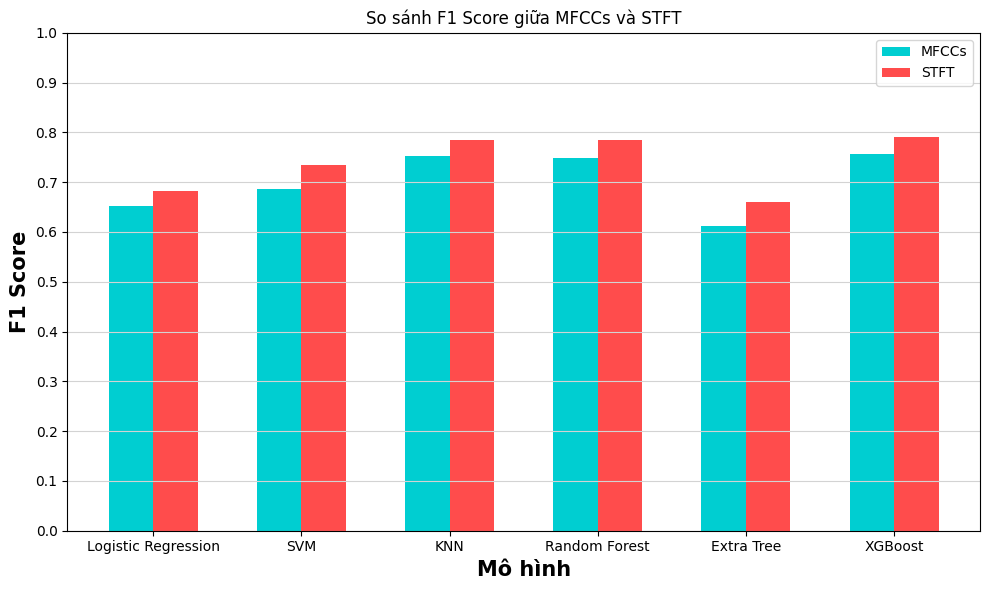

In [91]:
plt.figure(figsize=(10, 6))

br1 = np.arange(len(mfccs_df['Model']))
br2 = [x + 0.3 for x in br1]
plt.bar(br1, mfccs_df['F1 Score'], color='darkturquoise', width = 0.3)
plt.bar(br2, stft_df['F1 Score'], color='red', alpha=0.7, width = 0.3)
plt.xlabel('Mô hình', fontweight = 'bold', fontsize = 15)
plt.ylabel('F1 Score', fontweight = 'bold', fontsize = 15)
plt.title('So sánh F1 Score giữa MFCCs và STFT')
plt.xticks([r + 0.15 for r in range(len(mfccs_df['Model']))], mfccs_df['Model'])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(['MFCCs', 'STFT'])
plt.grid(axis = 'y', color = 'lightgrey')
plt.tight_layout()

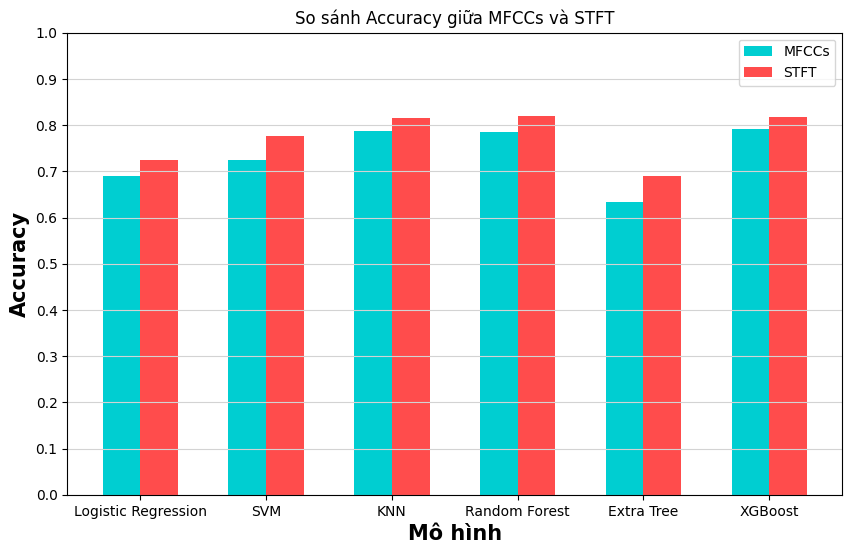

In [92]:
plt.figure(figsize=(10, 6))

br1 = np.arange(len(mfccs_df['Model']))
br2 = [x + 0.3 for x in br1]
plt.bar(br1, mfccs_df['Accuracy'], color='darkturquoise', width = 0.3)
plt.bar(br2, stft_df['Accuracy'], color='red', alpha=0.7, width = 0.3)
plt.xlabel('Mô hình', fontweight = 'bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight = 'bold', fontsize = 15)
plt.title('So sánh Accuracy giữa MFCCs và STFT')
plt.xticks([r + 0.15 for r in range(len(mfccs_df['Model']))], mfccs_df['Model'])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(['MFCCs', 'STFT'])
plt.grid(axis = 'y', color = 'lightgrey')

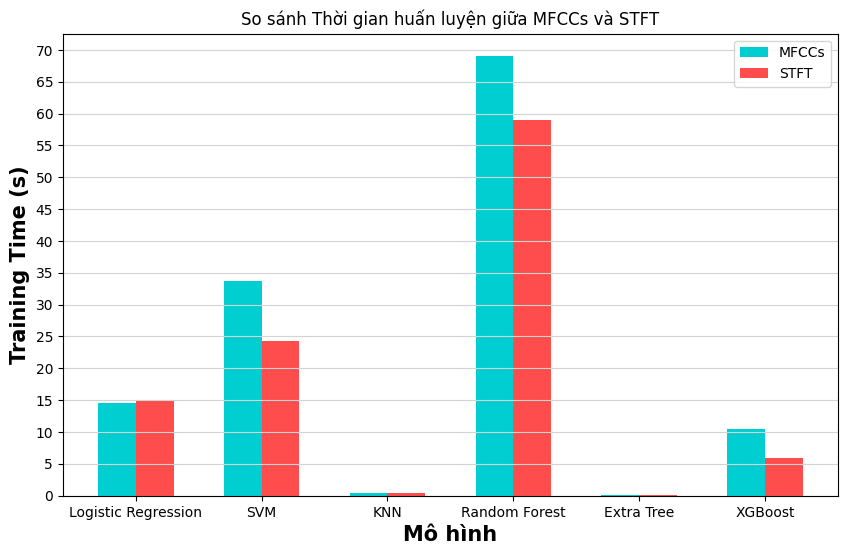

In [95]:
plt.figure(figsize=(10, 6))

br1 = np.arange(len(mfccs_df['Model']))
br2 = [x + 0.3 for x in br1]
plt.bar(br1, mfccs_df['Training Time (s)'], color='darkturquoise', width = 0.3)
plt.bar(br2, stft_df['Training Time (s)'], color='red', alpha=0.7, width = 0.3)
plt.xlabel('Mô hình', fontweight = 'bold', fontsize = 15)
plt.ylabel('Training Time (s)', fontweight = 'bold', fontsize = 15)
plt.title('So sánh Thời gian huấn luyện giữa MFCCs và STFT')
plt.xticks([r + 0.15 for r in range(len(mfccs_df['Model']))], mfccs_df['Model'])
plt.yticks(np.arange(0, 75, 5))
plt.legend(['MFCCs', 'STFT'])
plt.grid(axis = 'y', color = 'lightgrey')